# Column Densities with AbsComponent (v2.0)

In [1]:
%matplotlib inline

# suppress warnings for these examples
import warnings
warnings.filterwarnings('ignore')

In [2]:
# imports
import numpy as np
try:
    import seaborn as sns; sns.set(context="notebook",font_scale=2)
except:
    pass

from pkg_resources import resource_filename
from scipy import integrate
import astropy.units as u

from linetools.isgm import abscomponent as lt_abscomp
from linetools.spectralline import AbsLine
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList

In [3]:
ism = LineList('ISM')

read_sets: Using set file -- 
  /home/xavier/local/Python/linetools/linetools/lists/sets/llist_v1.2.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


## Read Spec

In [4]:
xspec = XSpectrum1D.from_file(resource_filename('linetools','/spectra/tests/files/UM184_nF.fits'))

## Generate a few AbsLines

In [5]:
SiIItrans = ['SiII 1260', 'SiII 1304', 'SiII 1526', 'SiII 1808']

In [6]:
abslines = []
for trans in SiIItrans:
    iline = AbsLine(trans,z=2.92939, linelist=ism)
    iline.limits.set([-250.,80.]*u.km/u.s) # vlim
    iline.analy['spec'] = xspec
    abslines.append(iline)
#
abslines

[<AbsLine: SiII 1260, z=2.9294 wrest=1260.4221 Angstrom, f=1.18>,
 <AbsLine: SiII 1304, z=2.9294 wrest=1304.3702 Angstrom, f=0.0863>,
 <AbsLine: SiII 1526, z=2.9294 wrest=1526.7070 Angstrom, f=0.127>,
 <AbsLine: SiII 1808, z=2.9294 wrest=1808.0129 Angstrom, f=0.00208>]

## Generate the Component

In [7]:
abscomp = lt_abscomp.AbsComponent.from_abslines(abslines)

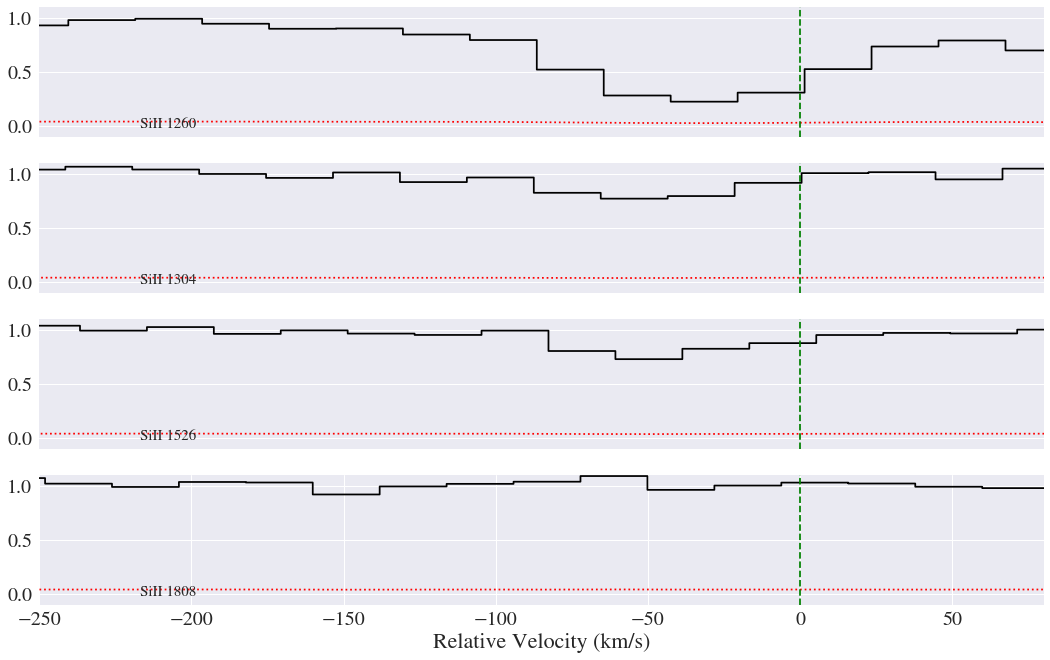

In [8]:
try:
    sns.set(context="notebook",font_scale=2)
except:
    pass
abscomp.stack_plot()

----

## Synthesize/Measure AODM Column Densities

In [9]:
abscomp.synthesize_colm(redo_aodm=True)

In [10]:
abscomp.logN

13.594445560856554

In [11]:
for iline in abscomp._abslines:
    print(iline.wrest, iline.attrib['flag_N'], iline.attrib['logN'], iline.attrib['sig_logN'])

1260.4221 Angstrom 1 13.5883729709 0.0150745701745
1304.3702 Angstrom 1 13.7708705955 0.0862006465248
1526.707 Angstrom 1 13.6707360009 0.0640855114473
1808.0129 Angstrom 3 0.0 0.509763872376


----

## Apparent Column Density Plot

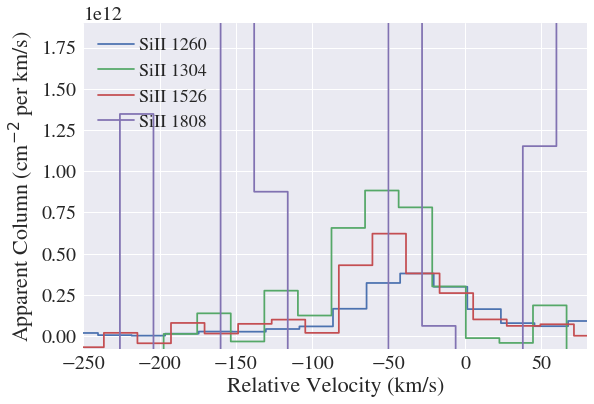

In [12]:
abscomp.plot_Na()

----

## COG

### $F(\tau_0)$

Definition
$F(\tau_0) = \int_0^\infty dx \, [1- \rm e^{-\tau_0 \rm e^{-x^2}}]$

In [13]:
def ftau_intgrnd(x,tau0=0.1):
    return 1 - np.exp(-tau0 * np.exp(-x**2))

In [14]:
neval = 10000
lgt = np.linspace(-3, 9, neval)
all_tau0 = 10.**lgt
Ftau = np.zeros(neval)
for jj,tau0 in enumerate(all_tau0):
    Ftau[jj], ferr = integrate.quad(ftau_intgrnd, 0, np.inf, args=(tau0,))

In [15]:
# Damped limit (not accurate enough)
damp_lgt = np.linspace(6, 10, 100)
damp_tau0 = 10.**damp_lgt
damp_Ftau = np.sqrt(np.log(damp_tau0))

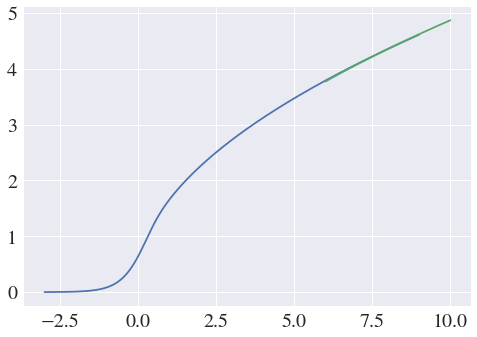

In [16]:
import matplotlib.pyplot as plt
plt.plot(lgt, Ftau, damp_lgt, 1.015*damp_Ftau)

### Perform and Plot

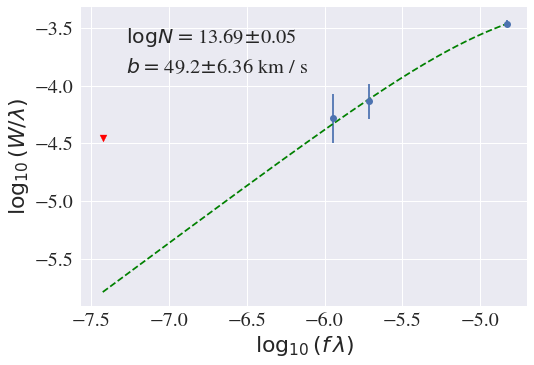

In [17]:
abscomp = lt_abscomp.AbsComponent.from_abslines(abslines)
COG_dict = abscomp.cog(redo_EW=True, show_plot=True)

In [18]:
# Output
COG_dict

{'EW': <Quantity [ 0.43129915, 0.06810455, 0.11137664,-0.01950807] Angstrom>,
 'b': <Quantity 49.22868767597288 km / s>,
 'f': array([ 1.18   ,  0.0863 ,  0.127  ,  0.00208]),
 'logN': 13.693355878125537,
 'parm': <single_cog_model(logN=13.693355878125537, b=49.22868767597288)>,
 'redEW': array([  3.42186280e-04,   5.22125891e-05,   7.29522068e-05,
         -1.07897867e-05]),
 'sig_EW': <Quantity [ 0.0129661 , 0.01440996, 0.01686854, 0.02102034] Angstrom>,
 'sig_b': <Quantity 6.356381185059459 km / s>,
 'sig_logN': 0.054323725737309987,
 'wrest': <Quantity [ 1260.4221, 1304.3702, 1526.707 , 1808.0129] Angstrom>}